# Lesson 4a: Hypothesis testing
some really good slides: https://indico.cern.ch/event/637941/contributions/2606105/attachments/1510179/2358420/limits_statistics_201708_sonneveld.pdf

Further reading: https://arxiv.org/pdf/hep-ex/9902006.pdf, https://arxiv.org/pdf/1007.1727.pdf

When we do a statistical interpretation, we are looking at one of two things: what is the significance of our signal, or what limit can we set on the relevant parameters in our analysis. In limits, we quantify the maximum effect some new physics could have at some model benchmark. There are multiple ways of doing this. On ATLAS, a common method is <b>CLs</b>. The "CL" stands for confidence level - but we don't determine a confidence level, rather an upper limit at some pre-specified confidence level. Generally, this is 95%, but occasionally you'll see others (e.g. 68%) CL limits specifically made to be comparable to results from other experiments.

In order to get to limits, we first need to define how to determine what is "more extreme": we need a *test statistic*.

Recall for a counting experiment, it was clear that the event count was a good test statistic: more events = more extreme. However, we would like to generalise this to more complicated scenarios.

## Type-I and Type-II errors

The ‘type-I’ error rate $\alpha$, also called the *size* of the test. This rate represent the false positive rate, e.g. unjustly convicted suspects in trial, or background events mistakenly accepted in the signal selection.

The ‘type-II’ error rate $\beta$, where $1−\beta$ is also called the *power* of the test. This rate represent the false negative rate, e.g mistakenly acquitted criminals or signal events mistakenly not selected in the signal region.

Let's illustrate this....

In [33]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson,norm,chi2
from scipy import stats
from iminuit import Minuit

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


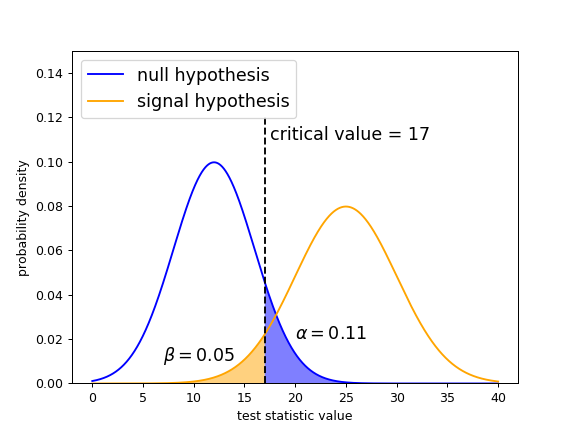

In [59]:
plt.close('all')
x_axis = np.arange(0,40, 0.001)
y1 = norm.pdf(x_axis,12,4)
y2 = norm.pdf(x_axis,25,5)
plt.plot(x_axis, y1, color='blue',label="null hypothesis")
plt.plot(x_axis, y2, color='orange',label="signal hypothesis")
ymin = np.zeros(len(y1))
critical_value = 17
ax = plt.gca()
ax.fill_between(x_axis, ymin, y2, where=x_axis <=critical_value, facecolor='orange', alpha=0.5)
ax.fill_between(x_axis, ymin, y1, where=x_axis >=critical_value, facecolor='blue', alpha=0.5)
ax.set_ylim(bottom=0,top=0.15)
ax.set_xlabel("test statistic value")
ax.set_ylabel("probability density")
alpha = norm.sf(critical_value,12,4)
beta = norm.cdf(critical_value,25,5)

ax.axvline(critical_value,0,0.8,color='black',linestyle='--')

plt.text(critical_value + 0.5, 0.11, 'critical value = '+str(critical_value), fontsize=14)

plt.text(critical_value + 3, 0.02, r'$\alpha = $'+'{:.2f}'.format(alpha), fontsize=14)
plt.text(critical_value - 10, 0.01, r'$\beta = $'+'{:.2f}'.format(beta), fontsize=14)

plt.legend(fontsize=14,loc='upper left')

plt.show()

If the observation falls *above* the critical value, we say we can reject the null hypothesis. This then comes along with a probability of being *wrong*, a type-I error, equal to $\alpha$.

What critical value do we need such that $\alpha = 0.05$, our standard for rejection?

If the result falls *below* the critical value, we say we accept the null hypothesis, but this comes along with a probability of wrongly rejecting the signal hypothesis, $\beta$.

The test *power* is defined as $1-\beta$, the probability of rejecting the null hypothesis when the signal hypothesis is true.

## Neyman-Pearson Lemma

Recall that if we want to classify a result as more or less "extreme" than observed, we need a test statistic from which to make this judgement. The Neyman-Pearson Lemma states that the *most powerful test statistic* is the ratio of the likelihoods:

\begin{align}
\lambda = \frac{L(H_{\mbox{s+b}} | \mbox{observation})}{L(H_{\mbox{b}} | \mbox{observation})}
\end{align}

when rejecting $H_{\mbox{b}}$ in favour of $H_{\mbox{s+b}}$ at a given significance level $\alpha =P(\lambda \leq \eta \mid H_{\mbox{b}})$ with a threshold $\eta$.

NOTE: any monotonic function of this also satisfies the lemma.


## Wilks' Theorem

In the large-sample limit, the likelihood approaches a gaussian (central limit theorem!) In this limit, the expression $-2 \ln Q$ follows a $\chi^2$ distribution with $m$ degrees of freedom, under the null hypothesis. It's a little confusing here, but the likelihood ratio used in default notation for Wilks' theorem isn't the same as the Neyman-Pearson Lemma - it's null / signal, rather than signal / null.

### Exercise: work this out!

If we have a large sample, we can use the large-sample limit and make an *asymptotic approximation*.

For example, if we go back to our original counting experiment, but now with more events so we don't immediately violate the asymptotic approximation right off the bat.
Take 250 background events and 300 observed events, where our predicted signal (in this test) is 40 events...

giving credit where credit is due: This bit of the lesson is from an example Stephen Menary provided to me.

In [90]:
def get_equiv_two_sided_gauss_significance (p, resolution=0.1, sigma_max = 8.) :
    x = np.linspace(sigma_max, 0, 1+int(sigma_max/resolution))
    y = 2.*(1. - norm.cdf(x))
    return np.interp([p], y, x)[0]

exp_sig = 40
exp_bkg = 250
exp_total = exp_sig+exp_bkg
obs_evts = 300
#approximate with a gaussian, since if we're using Wilks' theorem then we're already assuming gaussian-large numbers!
LHsb = 1-norm.cdf(obs_evts,exp_total,np.sqrt(exp_total))
LHb = 1-norm.cdf(obs_evts,exp_bkg,np.sqrt(exp_bkg))
nll = -2 * np.log(LHb/LHsb)

print 'L(Hs+b) = ',LHsb
print 'L(Hb) = ', LHb
print '-2lnQ = ', nll

p_chi2 = 1. - chi2.cdf(nll, 1)
z_chi2 = get_equiv_two_sided_gauss_significance(p_chi2)

print 'p-value for our chi2:',p_chi2
print 'this has a 2-sided Gaussian significance of:',z_chi2,'sigma'


L(Hs+b) =  0.2785279072047031
L(Hb) =  0.0007827011290012509
-2lnQ =  11.749045230955915
p-value for our chi2: 0.0006087445737461561
this has a 2-sided Gaussian significance of: 3.4312146889206816 sigma


In [71]:
## We can also validate Wilks' theorem by throwing toys, and making sure that they actually do follow a chi2 distribution
## First define some handy functions. 
def predicted_yield (s) :
    #s = signal strength
    return exp_bkg + s*exp_sig

def likelihood (s, data) :
    pred = predicted_yield(s)
    return stats.norm.pdf(data, pred, np.sqrt(pred))

def log_likelihood (s, data) :
    return np.log(likelihood(s, data))

def TNLL (s, data) :
    return -2. * log_likelihood(s, data)

def likelihood_ratio (s1, s2, data) :
    l1 = likelihood(s1, data)
    l2 = likelihood(s2, data)
    return l1 / l2

def log_of_likelihood_ratio (s1, s2, data) :
    return np.log(likelihood_ratio(s1, s2, data))

def TNLLR (s1, s2, data) :
    return -2. * log_of_likelihood_ratio(s1, s2, data)

n_toys = 10000
np.random.seed(100)
shifts = np.random.normal(size=n_toys)
toys_bkg = []

for shift in shifts :
    toys_bkg.append(exp_bkg   + np.sqrt(exp_bkg) * shift)

TNLLR_bkg_toys = []
for toy_bkg in toys_bkg :
    def eval_func(s) : return TNLL(s, toy_bkg)
    #solves here for the s (signal strength), given input bkg, that minimizes -2 ln L(H_{s*Ns+Nb})
    m = Minuit(eval_func, s=1, error_s=0.5, errordef=1)
    m.migrad()
    TNLLR_bkg_toys.append(TNLLR(0, m.values[0], toy_bkg))


/usr/local/bin/start_ipykernel.py:9: RuntimeWarning: invalid value encountered in sqrt
/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


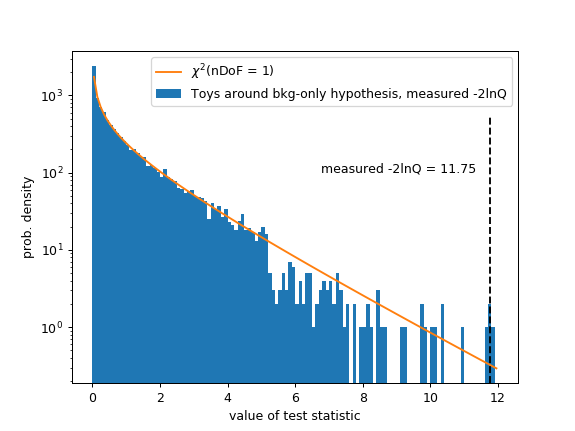

In [89]:
plt.close('all')
bin_edges   = np.linspace(0, 12, 121)
bin_centres = np.linspace(0.05, 11.95, 120)
plt.hist(TNLLR_bkg_toys, bins=bin_edges, label="Toys around bkg-only hypothesis, measured -2lnQ")
plt.plot(bin_centres, chi2.pdf(bin_centres, 1)*0.1*n_toys, label="$\chi^2$(nDoF = 1)")
plt.legend(loc="upper right")
plt.ylabel("prob. density")
plt.xlabel("value of test statistic")
plt.gca().set_yscale("log")
ax = plt.gca()
ax.axvline(nll,0,0.8,color='black',linestyle='--')

plt.text(nll-5, 100, 'measured -2lnQ = '+'{:.2f}'.format(nll), fontsize=10)


plt.show()


## But what if we don't have sensitivity? 

This is where procedures like $\mbox{CL}_{s}$ come in. Let's go back to our original counting experiment - 5 background, 9 observed, 5 predicted signal with signal strength = 1.

The $CLs$ method says we can exclude a signal at 95\% confidence level (CL) if $\mbox{CL}_s < 0.05$, where $\mbox{CL}_s \equiv \mbox{CL}_{s+b}~ /~ \mbox{CL}_{b}$.

==> next week, in lesson 4b!
